## Work package 1.2 
### This notebook demonstrates running water quality measures using a multi-sensor approach, for an area of interest.
Note that:
- an area / domain of interst is assumed as a start point
- the processing resolution is determined from the space-time size of the AOI, in part to remain within sandbox memory limitations
- 
   

### Dependencies etc.

In [1]:
# --- --- 
import datacube
import numpy as np
import xarray as xr
import scipy as sp
import gc
from scipy import stats

dc = datacube.Datacube(app='DoinWhatImdoin') #testing what difference the 'app' value makes...

In [2]:
# --- run code for functions that are called
%run _WQ_functions.py
%run _Build_annual_dataset-1.0.ipynb   #for now I have kept these functions in a notebook for the markdown

In [3]:
# --- controlling parameters and settings
verbose = True
test    = False
max_cells = 100000   #use this to test memory limits. Memory saving steps are going to be needed...

In [4]:
# --- get the dictionary of all possible places for analysis ---
places_dict     = set_spacetime_domain()   
# --- extract an AOI for a given placename (could iterate through the dictionary keys as an alternative)
placename = 'Lake_Sulunga'   
placename = 'Ghana_River'   
placename = 'Lake_Tikpan'   
placename = 'Lake_vic_turbid'   
placename = 'SA_smalldam'   
placename = 'SA_smalldam1' 
placename = 'Lake_Manyara'
placename = 'Lake Awassa'
placename = 'Lake Ziway'
placename = 'Lake Elmenteita'
placename = 'Lake Chamo'

# --- the functions set_spacetime_domain is used here to set a bunch of processing parameters
# --- when operationalising, this must be replaced but an approach that iterates through tiles or waterebodiies

spacetime_domain, grid_resolution, cell_area, resampling_option, year1, year2 \
                           = set_spacetime_domain(placename,'2000','2024',max_cells,verbose,False)     

Lake Chamo AOI:  {'x': (37.45, 37.65), 'y': (5.685, 5.979), 'time': ('2000', '2024')} Lake Chamo, Ethiopia
Grid resolution will be: (70, 70)
Rough dimensions (x,y):  19  by  29 kilometres
Total cells is roughly:  119409
Cell area is:  0.0049  km2
Resampling : nearest
Site name:  Lake Chamo, Ethiopia
Years: 2000 2024


In [5]:
set_spacetime_domain()

{'Lake_Baringo': {'run': True,
  'xyt': {'x': (36.0, 36.17), 'y': (0.45, 0.74), 'time': ('2000', '2024')},
  'desc': 'Lake Baringo'},
 'Lake_Tikpan': {'run': True,
  'xyt': {'x': (1.8215, 1.8265),
   'y': (6.459, 6.4626),
   'time': ('2000', '2024')},
  'desc': 'Lake Tikpan'},
 'Lake_Chad': {'run': True,
  'xyt': {'x': (12.97, 15.5), 'y': (12.4, 14.5), 'time': ('2000', '2024')},
  'desc': 'Lake Chad'},
 'Weija_Reservoir': {'run': True,
  'xyt': {'x': (-0.325, -0.41), 'y': (5.54, 5.62), 'time': ('2000', '2024')},
  'desc': ''},
 'Senegal_StLouis': {'run': True,
  'xyt': {'x': (-15.74, -15.84), 'y': (16.3, 16.39), 'time': ('2000', '2024')},
  'desc': 'Lac de Guiers'},
 'Lake_Sulunga': {'run': True,
  'xyt': {'x': (34.95, 35.4), 'y': (-6.3, -5.8), 'time': ('2000', '2024')},
  'desc': ''},
 'few_pixels': {'run': False,
  'xyt': {'x': (33.16, 33.16005),
   'y': (-2.12, -2.1424),
   'time': ('2000', '2024')},
  'desc': ''},
 'small_area': {'run': False,
  'xyt': {'x': (33.1655, 33.1864),
   

### Build a multi-sensor dataset 
- flexibility is key here, and consistent naming so that measurements from multiple sensors can be unambiguously included in a single dataset for analysis
- keeping all data in a single dataset simplifies subsequent steps and retains flexibility, e.g., to add in new water quality algorithms
- a dictionary of instruments and sensors is used to rename all measurements to a common form
- since we are using annual geomedians, we don't need to harmonise dates, at this point, except for when using temperature data
- the approach is designed to be extendable to monthly composites


#### set a list of 'instruments' to be used in the analysis. Once methods are all in place this will not change except to support improvements.
- instrument names are used rather than satellite names, to avoid confusionFor these purposes, wofs is also an instrument name.
- the list is set up to be resuable when we move from geomedians to monthly composites


oli_agm True
oli False
msi_agm True
msi False
tm_agm True
tm False
tirs True
wofs_ann True
wofs_all False

Building the dataset:
loading data for  oli_agm ...
loading data for  msi_agm ...
loading data for  tm_agm ...
loading data for  tirs ...
loading data for  wofs_ann ...


/opt/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/opt/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/opt/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/opt/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/opt/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/opt/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/opt/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered

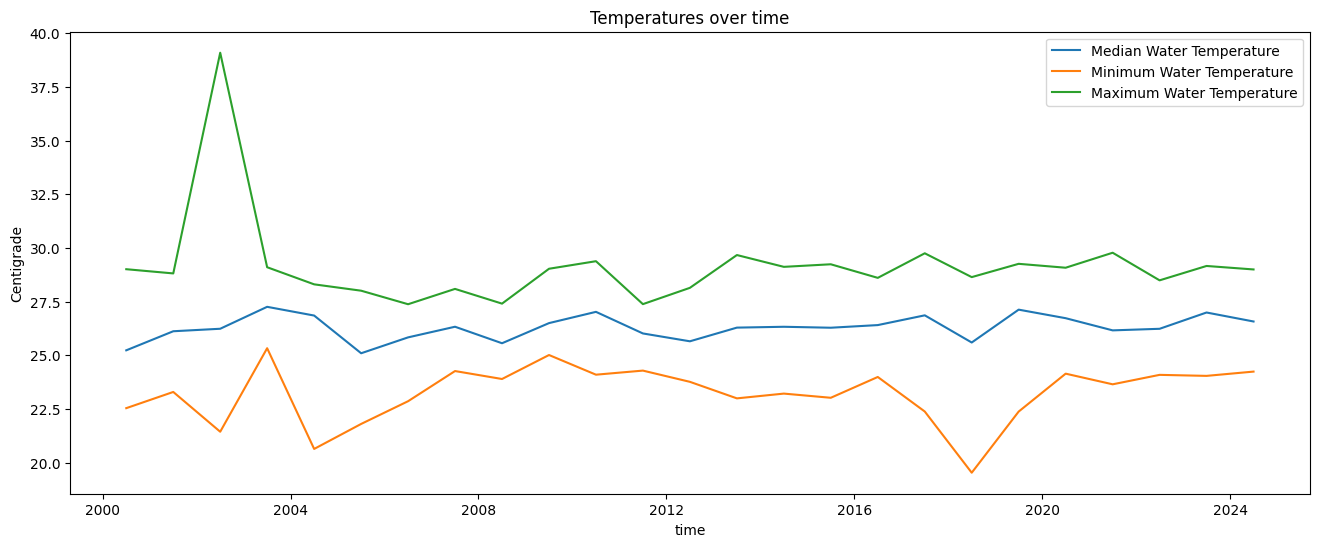

In [45]:
# --- set which instruments to use (this is checked later against the date range for each place)
# --- for Phase1, mapping, the main datasets are the geomedians. For monioring the local time-seres will be brought in as well as the geomedians.
# --- temperature is yet to be included.

_instruments_to_use = {
    'oli_agm'  : {'use': True },
    'oli'      : {'use': False},
    'msi_agm'  : {'use': True },
    'msi'      : {'use': False},
    'tm_agm'   : {'use': True },
    'tm'       : {'use': False},
    'tirs'     : {'use': True},  
    'wofs_ann' : {'use': True },
    'wofs_all' : {'use': False },  # wofs_all will be removed as it is better to derive from wofs_ann
    }
instruments_to_use = _instruments_to_use.copy()  #using a copy is helpful sometimes..

# --- don't try to use instruments for which there are no data 
check_instrument_dates(instruments_to_use,int(year1),int(year2))

# --- build the multivariate/multi-sensor dataset. 
#     Datacube calls are made to extract the primary data. 
#     Variables are-re-named and merged to a single dataset ---

ds             = build_wq_agm_dataset(spacetime_domain,instruments_to_use,verbose = verbose)

# --- retain a dictionary of the instruments and measurements that are on-hand ---
instruments    = instruments_list(instruments_to_use)[0]  # a list of the instruments  in use
            

In [115]:
ds.chla.loc[dict(chla_measure='ndci_tm43_agm')].median(dim=('x','y'))*53 + 28

<xarray.DataArray 'chla' (time: 25)> Size: 200B
array([20.80991061, 15.17611031, 16.5885167 , 11.45859927, 18.5004054 ,
       12.98951095, 12.73274842, 24.56127715, 13.90671316, 14.67092907,
       13.60703024, 16.69218238, 13.19735724,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])
Coordinates:
  * time          (time) datetime64[ns] 200B 2000-07-01T23:59:59.999999 ... 2...
    spatial_ref   int32 4B 6933
    chla_measure  <U20 80B 'ndci_tm43_agm'

### Determine pixels that are water (sometimes, usually, permanent)

In [62]:
# --- controling parameters for water mapping on a pixel by pixel basis ---
WFTH = water_frequency_threshold_high = 0.5    #this threshold targets areas that are as like as not to be water at any time.
WFTL = water_frequency_threshold_low  = 0.1    #for pixel processing (rather than during summation)
PWT  = permanent_water_threshold      = 0.875  #used to map annual permanent water (value arrived at through testing)
SC   = sigma_coefficient              = 1.2    #used to map annual permanent water (value arrived at through tessting)
ds   = water_analysis(ds,
                   water_frequency_threshold= WFTH,
                   wofs_varname             = 'wofs_ann_freq',
                   permanent_water_threshold= PWT,
                   sigma_coefficient        = SC,
                   verbose                  = verbose,
                   test                     = test)

### Pixel corrections

R_correction completed normally


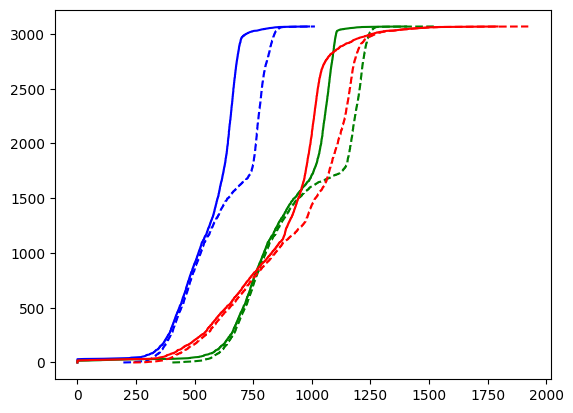

In [49]:
# --- dark Pixel correction, the 'dp_adjust' dictionary controls which variables are used as a reference, 
#     and which are changed in the dark-pixel correction
#     Add entries to cater for non-geomedian situations.

dp_adjust = { 
        'msi_agm': {'ref_var':'msi12_agm','var_list': ['msi04_agm','msi03_agm','msi02_agm','msi05_agm','msi06_agm', 'msi07_agm']},
        'oli_agm': {'ref_var':'oli07_agm','var_list': ['oli04_agm','oli03_agm','oli02_agm']},
        'tm_agm' : {'ref_var':'tm07_agm', 'var_list': ['tm04_agm','tm03_agm','tm02_agm','tm01_agm']}
        }
ds = R_correction(ds,dp_adjust,instruments,water_frequency_threshold_low,verbose=verbose,test=test)

### Hue; calculation of the hue value

In [50]:
if not (('msi_agm') in instruments.keys()):
    print("skipping hue calculation as the msi_agm instrument is not in the dataset")
else: 
    ds['hue'] = hue_calculation(ds,instrument='msi_agm',test=test,verbose=verbose)[0]

Average Hue values post-ajustment : [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan 41.3 41.5 42.3 43.8 44.2 43.1 43.1 45.6]


### Optical Water Type (OWT)
The algorithm compares each pixel's band values with 13 reference spectra based on the spectral angle. Therefore, for each pixel 13 dot products are calculated. 
Memory intensive, data are down-sampled for processing. 
Methods as per Spyrakos et al 2018. - code here caters for msi_agm and oli_agm sensors (ie., the annual geomedian), but easily adapted to msi and oli through dictionary entries
OWT is estimated from the spectral angle between the pixel and the refence spectra for each of the 13 OWTs
- extension to other sensors (TM, OLCI) also quite straightforward but the OWT refence data would need to be brought in.

we can do this for Landsat and for Sentinel, however in the geomedian 
- OLI has only 3 available bands (2,3,4) - missing band 1
- MSI has only 6  of 7 useful bands (missing band 1) 
- TM  has 4  (all of 1,2,3,4)

**To do, ideally : Upload the full reference spectra and establish an import function to bring in as a data array.**
- Here, I have estimated the mean band reflectance for each sensor in excell using the spectral response curves (MSI response functions are available on-line) and used the results directly 

#### Zhang et al. group the OWTs as follows:
- oligotrophic (clear)           : 3, 9, 13           (apply NASA OCx model for ChlA) - we don't see much of this!!!
- eutopic and bluegreen waters   : 1, 2, 4, 5, 11, 12 (apply two band models of Gurlin et al for ChlA)
- hypereutrophic and green-brown : 6, 7, 8, 10        (apply TC2 alg for ChlA)   

In [51]:
ds['owt_msi'] = OWT_pixel(ds,'msi_agm',water_frequency_threshold=0.8,resample_rate=3,verbose=False, test=True)        


In [52]:
ds.owt_msi.median(dim=('x','y'))

<xarray.DataArray 'owt_msi' (time: 25)> Size: 200B
array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10.,  7.,  7., 10., 10., 11.])
Coordinates:
  * time         (time) datetime64[ns] 200B 2000-07-01T23:59:59.999999 ... 20...
    spatial_ref  int32 4B 6933

### Calculate the raw (i.e. not harmonised) water quality measurements and indices
- A dictionary is used to manage water quality algorithms and the bands that are used in them. This retains flexibility (e.g. algorithms can be run with multiple sensors) and avoids errors
- NEW DIMENSIONS are added to the dataset to house the results. One dimension is added called 'chla', and one called 'tss'. This appraoch simplifies later processing when we want to pool the measures as an ensemble. (For simplicity, I may remove this and bring in at a later stage..)



In [53]:
# ----  dictionary of instruments, bands, algorithms, and  functions -----------------------   

ndci_nir_r   =  { 
                "msi_agm"   : {'54' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi54_agm'       ,'args' : {"NIR_band" : 'msi05_agmr', "red_band":'msi04_agmr'}},
                               '64' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi64_agm'       ,'args' : {"NIR_band" : 'msi06_agmr', "red_band":'msi04_agmr'}},
                               '74' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi74_agm'       ,'args' : {"NIR_band" : 'msi07_agmr', "red_band":'msi04_agmr'}}},
                "tm_agm"    : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_tm43_agm'                ,'args' : {"NIR_band" : 'tm04_agm'  , "red_band":'tm03_agmr'}},
                "oli_agm"   : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_oli54_agm'               ,'args' : {"NIR_band" : 'oli05_agm' , "red_band":'oli04_agmr'}}
                }

chla_meris2b = {"msi_agm" : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi_agm' ,'args' : {"band_708" : 'msi05_agmr', "band_665":'msi04_agmr'}},
                    "msi"     : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi'     ,'args' : {"band_708" : 'msi05'     , "band_665":'msi04'}}}

chla_modis2b = {"msi_agm" : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi_agm' ,'args' : {"band_748" : 'msi06_agmr', "band_667":'msi04_agmr'}},
                    "msi"     : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi'     ,'args' : {"band_748" : 'msi06'     , "band_667":'msi04'}},
                    "tm_agm"  : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_tm_agm'  ,'args' : {"band_748" : 'tm04_agmr' , "band_667":'tm03_agmr'}}}

ndssi_rg     = {"msi_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi_agm'       ,'args' : { "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                "msi"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi'           ,'args' : { "red_band":'msi04r'    , "green_band":'msi03_agmr'}},
                "oli_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli_agm'       ,'args' : { "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                "oli"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli'           ,'args' : { "red_band":'oli04r'    , "green_band":'oli03r'    }},
                "tm_agm"  : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm_agm'        ,'args' : { "red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                "tm"      : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm'            ,'args' : { "red_band":'tm03r'     , "green_band":'tmi02r'    }}}

ndssi_bnir   = {#"msi_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi_agm'     ,'args' : { "NIR_band":'msi08_agmr', "blue_band":'msi02_agmr'}},
                "msi"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi'         ,'args' : { "NIR_band":'msi08'     , "blue_band":'msi02_agmr'}},
                "oli_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli_agm'     ,'args' : { "NIR_band":'oli06_agm' , "blue_band":'oli02_agmr'}},
                "oli"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli'         ,'args' : { "NIR_band":'oli06'     , "blue_band":'oli02r'    }},
                #"tm_agm"  : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm_agm'      ,'args' : { "NIR_band":'tm04_agm'  , "blue_band":'tm01_agmr' }},
                "tm"      : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm'          ,'args' : { "NIR_band":'tm04'     , "blue_band":'tm01r'    }}}


ti_yu        = {#"msi_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi_agm'        ,'args' : {"NIR" : 'msi08_agmr', "Red":'msi04_agmr', "Green":'msi03_agmr'}},
                    "msi"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi'            ,'args' : {"NIR" : 'msi08'     , "Red":'msi04r'    , "Green":'msi03_agmr'}},
                    "oli_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli_agm'        ,'args' : {"NIR" : 'oli06_agm' , "Red":'oli04_agmr', "Green":'oli03_agmr'}},
                    "oli"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli'            ,'args' : {"NIR" : 'oli06'     , "Red":'oli04r'    , "Green":'oli03r'    }},
                    "tm_agm"  : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm_agm'         ,'args' : {"NIR" : 'tm04_agm'  , "Red":'tm03_agmr' , "Green":'tm02_agmr' }},
                    "tm"      : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm'             ,'args' : {"NIR" : 'tm04'      , "Red":'tm03r'     , "Green":'tmi02r'    }}}

tsm_lym      = {"oli_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "msi_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr' }},
                    "msi"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }},
                    "tm_agm"  : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }}}

spm_qiu      = {"oli_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "tm_agm"  : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }},
                    "msi_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                    "msi"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }}}

tss_zhang        = {"msi_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi_agm' ,'args' : {"blue_band" : 'msi02_agmr', "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                        "msi"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi'     ,'args' : {"blue_band" : 'msi02r'    , "red_band":'msi04r'    , "green_band":'msi03_agmr'}},
                        "oli_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli_agm' ,'args' : {"blue_band" : 'oli02_agmr', "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                        "oli"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli'     ,'args' : {"blue_band" : 'oli02r'    , "red_band":'oli04r'    , "green_band":'oli03r'    }}}

# ---- algorithms are grouped into two over-arching dictionaries ---- 
algorithms_chla = {"ndci_nir_r"   : ndci_nir_r, 
                       "chla_meris2b" : chla_meris2b, 
                       "chla_modis2b" : chla_modis2b}
algorithms_tsm  = {"ndssi_rg"     : ndssi_rg  , 
                       "ndssi_bnir"   : ndssi_bnir, 
                       "ti_yu"        : ti_yu     ,
                       "tsm_lym"      : tsm_lym   ,
                       "tss_zhang"    : tss_zhang ,
                       "spm_qiu"      : spm_qiu    }

In [54]:
# ---- Apply the WQ algorithms to water areas, adding variables to the dataset and building  a list of water quality variable nanmes
# -- this can be run either keeping the wq variables as separate variables on the dataset, or by moving them into new dimensions, 'tss' and 'chla'
# -- If the arguments 'new_dimension_name' or 'new_varname' are None (or empty), then the outputs will be retained as separate variables in a 3d dataset

if True: #put the data into a new dimension, call the variable 'tss' or 'chla'
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name='tss_measure', 
                        new_varname='tss', 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name='chla_measure', 
                        new_varname='chla',
                        verbose=verbose)

else:  #keep it simple, just add new data as new variables in a 3-D dataset 
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None, 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None,
                        verbose=verbose)
wq_varlist = np.append(tsm_vlist,chla_vlist)


NDSSI_RG
NDSSI_RG
NDSSI_RG
NDSSI_BNIR
TI_yu
TI_yu
TSM_LYM_OLI
TSM_LYM_OLI
TSM_LYM_ETM
TSS_Zhang
TSS_Zhang
SPM_QIU
SPM_QIU
SPM_QIU
ChlA_MERIS two-band model
ChlA_MODIS two-band model
ChlA_MODIS two-band model


In [55]:
# ---- tidy up by dropping excess variables ---
keeplist = ('wofs_ann_clearcount','wofs_ann_wetcount','wofs_ann_freq','wofs_ann_freq_sigma','wofs_pw_threshold','wofs_ann_pwater','watermask','owt_msi','tss','chla')
#the keeplist is not complete; if the wq variables are retained as variables they will appear in a listing of data_vars. 
#therefore, revert to the instruments dictionary to list variables to drop
droplist = []
for instrument in list(instruments.keys()):
    for band in list(instruments[instrument].keys()):
        variable = instruments[instrument][band]['varname']
        if not (variable in keeplist): 
            droplist=np.append(droplist,variable)
            droplist=np.append(droplist,variable+'r')
for varname in droplist:
    if varname in ds.data_vars:
        ds = ds.drop_vars(varname)
    

### And we are Done... :)

In [116]:
ds['wofs_ann_confidence'] = xr.where(ds.wofs_ann_freq >0,
            ((1.0 - (ds.wofs_ann_freq_sigma/ds.wofs_ann_freq)) * 100).astype('int16'),
            np.nan)

/opt/venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:236: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [ ]:
#export the dataset as an input for the next step:
ds.to_netcdf("../WP1.4/wp12_ds_"+placename+".nc")

In [58]:
placename

'Lake Chomo'

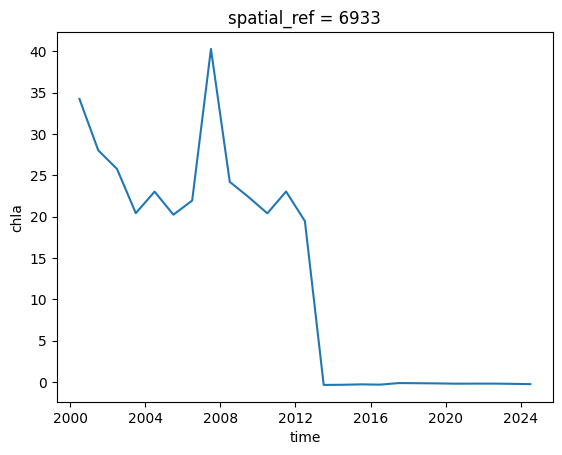

In [59]:
ds.chla.median(dim=('chla_measure')).median(dim=('x','y')).plot()

In [42]:

ds.data_vars


Data variables:
    wofs_ann_freq        (time, y, x) float32 7MB nan nan nan ... 1.0 1.0 1.0
    wofs_ann_clearcount  (time, y, x) float64 14MB nan nan nan ... 28.0 27.0
    wofs_ann_wetcount    (time, y, x) float64 14MB nan nan nan ... 28.0 27.0
    wofs_ann_freq_sigma  (time, y, x) float64 14MB nan nan nan ... 0.0 0.0 0.0
    wofs_ann_confidence  (time, y, x) float64 14MB nan nan nan ... 100.0 100.0
    wofs_pw_threshold    (time, y, x) float64 14MB nan nan nan ... 0.875 0.875
    wofs_ann_pwater      (time, y, x) float32 7MB nan nan nan ... 1.0 1.0 1.0
    wofs_ann_water       (time, y, x) float32 7MB nan nan nan ... 1.0 1.0 1.0
    watermask            (time, y, x) float64 14MB nan nan nan ... 0.0 0.0 0.0
    hue                  (time, y, x) float64 14MB nan nan nan ... 40.3 40.39
    owt_msi              (time, y, x) float64 14MB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 141MB nan ... 126.5
    chla                 (time, y, x, chla_m